# Modelo para Análisis de sentimientos

### Importando librerías

In [61]:
import pandas as pd

import spacy

import nltk
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, ngrams
from collections import defaultdict
from string import punctuation

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lordm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Funciones

In [87]:
def generador_tokens(text, remove_stopwords=False, lemmatize=False, include_punctuation=False):

    # Tokenización
    tokens = word_tokenize(text)

    # Eliminar signos de puntuación
    if include_punctuation:
        punctuations = list(punctuation)
        tokens = [word for word in tokens if word.isalnum() and word not in punctuations]

    # Eliminar stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('spanish'))
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Lematización
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def generador_grama(df, n, remove_stopwords=False, lemmatize=False, remove_punctuation=False):
  gram_generate = defaultdict(int)

  # Procesando cada opinión
  for row in df:
      opinion = row
      
      # Preprocesando el texto de la opinión y generador de tokens
      tokens = generador_tokens(opinion, remove_stopwords, lemmatize, remove_punctuation)
        
      # Generando trigramas
      n_grams = ngrams(tokens, n)
        
      # Actualizando el puntaje de los trigramas
      for gram in n_grams:
        gram_generate[gram] += 1
  
  return gram_generate

# Evaluación de un texto
# Regresa un score donde se suman las frecuencias de los n-gramas positivos y se restan las frecuencias de los n-gramas negativos
def evaluar_texto(texto, frec_positivos, frec_negativos, n):
    
    punctuations = list(punctuation)

    score = 0

    # Tokenización con NLTK
    words = [t for t in nltk.word_tokenize(texto) if t not in punctuations]
    #print(words)

    for n_grama in ngrams(words, n):
        score += frec_positivos[n_grama]
        score -= frec_negativos[n_grama]
        #print(n_grama, "+", frec_positivos[n_grama], "-", frec_negativos[n_grama])     
    return score


# Clasificación del score
def clasificar(score):
    if score >= 0:  #Positivo
        return 1
    else:
        return 0    #Negativo

### Entrenamiento

In [88]:
# Número de n-gramas
n = 4

train = pd.read_csv('../data/processed/train.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

val = pd.read_csv('../data/processed/val.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

train_opiniones_positivas = train[train['Label'] == 1]['Opinion']

train_opiniones_negativas = train[train['Label'] == 0]['Opinion']

# Modelo de conteos de n_gramas
frec_positivos = defaultdict(int) 
frec_negativos = defaultdict(int) 

frec_positivos = generador_grama(train_opiniones_positivas, n, remove_stopwords=True, lemmatize=True,remove_punctuation=True)
frec_negativos = generador_grama(train_opiniones_negativas, n, remove_stopwords=True, lemmatize=True,remove_punctuation=True)

### Evaluación

In [89]:
texto = 'hay una leyenda acerca de este lugar que me parece la de\nromeo y julieta de guanajuato, no la cuento completapara \nque quieran llegar, a mi me parecio muy romantica y este\nlugar debe ser un sitio obligatorio para todas las parejas que\nvisiten guanajuato, así atraeran sus siete años de buena\nsuerte'
evaluar_texto(texto, frec_positivos, frec_negativos, n)

0

In [90]:
# Copia del conjunto de validación
df_val_opiniones = val.copy()

df_val_opiniones['Score'] = df_val_opiniones['Opinion'].apply(lambda x: evaluar_texto(x, frec_positivos, frec_negativos, n))
df_val_opiniones['Clasificación'] = df_val_opiniones['Score'].apply(clasificar)


In [91]:
from sklearn.metrics import f1_score

f1_score = f1_score(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])

print(f'F1 Score:', f1_score)

F1 Score: 0.9029430181590481


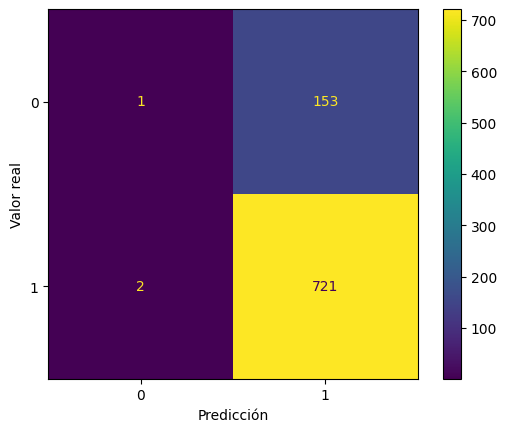

In [85]:
# Plot matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

In [28]:
print(classification_report(df_val_opiniones['Label'], df_val_opiniones['Clasificación']))

              precision    recall  f1-score   support

           0       0.59      0.12      0.20       154
           1       0.84      0.98      0.91       723

    accuracy                           0.83       877
   macro avg       0.72      0.55      0.55       877
weighted avg       0.80      0.83      0.78       877



In [29]:
df_val_opiniones['Clasificación'].value_counts()

Clasificación
1    845
0     32
Name: count, dtype: int64

In [30]:
# Verdaderos positivos y Verdaderos negativos
df_val_opiniones['Label'].value_counts()

Label
1    723
0    154
Name: count, dtype: int64